## **🔄 Cell 1 — Start Fresh**
Before diving into training, we first clean up any leftover files from previous runs.  
This ensures we’re starting with a clean environment and avoids unexpected conflicts.  

- Remove old model checkpoints and training history logs  
- Clear cached Python bytecode (`__pycache__`)  
- Free up any leftover GPU memory  

Finally, we print a confirmation that we’re ready to continue with a clean slate.  


In [ ]:
# Remove previous artifacts for a clean run
!rm -f /content/deeplabv3_abdomenus_best.pt /content/deeplabv3_training_history.*
!rm -rf /content/__pycache__
import gc, torch
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
print("Clean slate.")


Clean slate.


## **📦 Cell 2 — Install & Import Dependencies**
Here, we install and import the core tools needed for our segmentation project:  

- **medsegbench** → library for medical image segmentation  
- **PyTorch & Torchvision** → deep learning framework  
- **Matplotlib & Pillow** → visualization and image handling  
- **SciPy** → extra scientific computing utilities  

We also bring in some Python utilities (`os`, `sys`, `random`, etc.).  
At the end, we check and display key environment details like Python version,  
PyTorch version, and CUDA availability.  


In [ ]:
!pip -q install --upgrade medsegbench torch torchvision matplotlib pillow scipy

import os, sys, random, hashlib, subprocess, json
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Python:", sys.version)
print("Torch :", torch.__version__)
print("CUDA  :", torch.cuda.is_available())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 13.8 MB/s eta 0:00:00
Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Torch : 2.8.0+cu126
CUDA  : True


## **🎲 Cell 3 — Reproducibility Setup**
To make experiments consistent and reproducible, we set a random seed (`SEED=42`) across:  

- Python’s built-in `random`  
- NumPy  
- PyTorch (CPU and GPU if available)  

We also configure PyTorch backend options for deterministic behavior.  
This helps ensure that if we rerun training, results stay consistent.  
Finally, we print the seed value and the device being used (CPU or GPU).  


In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
print(f"Reproducibility set with SEED={SEED} | DEVICE={DEVICE}")


Reproducibility set with SEED=42 | DEVICE=cuda


## **📂 Cell 4 — Dataset Setup & Download**
Now we prepare our dataset for training.  

- **Define size**: we set the input size to `256 x 256`.  
- **Set storage directory**: create a local folder (`~/.medsegbench`) to store the dataset and tell the system where to find it.  
- **Dataset info**: specify the filename, download link, and expected MD5 checksum (for file integrity).  

We include a helper function to calculate the MD5 hash of the file and verify it after download.  

Steps performed:  
1. Check if the dataset file already exists locally.  
2. If not, attempt to download it using `curl` (or fall back to `wget` if needed).  
3. Verify that the downloaded file matches the expected MD5 checksum to ensure data integrity.  
4. Confirm when the dataset is ready for use.  


In [ ]:
SIZE = 256
root = os.path.expanduser("~/.medsegbench")
os.makedirs(root, exist_ok=True)
os.environ["MEDSEGBENCH_DIR"] = root

target_name = f"abdomenus_{SIZE}.npz"
target_path = os.path.join(root, target_name)
url = "https://zenodo.org/records/13358372/files/abdomenus_256.npz?download=1"
expected_md5 = "c2eb21d1a93d857c472b01a72a210030"

def md5sum(path):
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(8192), b""):
            h.update(chunk)
    return h.hexdigest()

if not os.path.exists(target_path):
    print(f"Downloading to {target_path} ...")
    try:
        subprocess.run(["curl", "-L", "-f", url, "-o", target_path], check=True)
    except subprocess.CalledProcessError:
        print("curl failed; trying wget...")
        subprocess.run(["wget", "-O", target_path, url], check=True)
else:
    print("File already present:", target_path)

got = md5sum(target_path)
print("MD5:", got)
if got != expected_md5:
    raise RuntimeError(f"MD5 mismatch for {target_name}. Expected {expected_md5}, got {got}.")
print("✅ Dataset ready at", target_path)


MD5: c2eb21d1a93d857c472b01a72a210030
✅ Dataset ready at /root/.medsegbench/abdomenus_256.npz


## **📊 Cell 5 — Load Abdomen Ultrasound Dataset**
With the dataset prepared, we now load it into memory using **`medsegbench`**.  

- **Train split** → used for model learning  
- **Validation split** → used to tune and check performance during training  
- **Test split** → held-out data to evaluate final model performance  

We set the image size to `256x256` (same as before) and skip downloading since the dataset is already available locally.  

Finally, we print out the number of samples in each split along with the image size to confirm everything loaded correctly.  


In [ ]:
from medsegbench import AbdomenUSMSBench

train_ds_raw = AbdomenUSMSBench(split="train", size=SIZE, download=False)
val_ds_raw   = AbdomenUSMSBench(split="val",   size=SIZE, download=False)
test_ds_raw  = AbdomenUSMSBench(split="test",  size=SIZE, download=False)

print(f"Train: {len(train_ds_raw)} | Val: {len(val_ds_raw)} | Test: {len(test_ds_raw)} (size={SIZE})")


Train: 569 | Val: 64 | Test: 293 (size=256)


## **🖼️ Cell 6 — Utility Functions for Images & Masks**
To make visualization easier, we define two helper functions:  

1. **`to_numpy_image(x)`**  
   - Converts an input (PIL image or PyTorch tensor) into a NumPy array.  
   - Handles both grayscale and RGB images.  
   - Ensures the image is in the correct shape (`H x W x C`) and normalized to values between `0` and `1`.  

2. **`to_numpy_mask(m)`**  
   - Converts a mask (PIL image or PyTorch tensor) into a NumPy array.  
   - Ensures the mask values are integers (`int64`) so they can be used for segmentation tasks.  

These functions standardize images and masks into a consistent format, making them ready for visualization and model processing.  


In [ ]:
def to_numpy_image(x):
    if "PIL" in str(type(x)):
        x = np.array(x)
    elif isinstance(x, torch.Tensor):
        x = x.detach().cpu().numpy()
        if x.ndim == 3 and x.shape[0] in (1,3):
            x = np.transpose(x, (1,2,0))
    x = x.astype(np.float32)
    if x.ndim == 2:
        x = np.stack([x, x, x], axis=-1)
    if x.max() > 1.5:
        x /= 255.0
    return x

def to_numpy_mask(m):
    if "PIL" in str(type(m)):
        m = np.array(m)
    elif isinstance(m, torch.Tensor):
        m = m.detach().cpu().numpy()
    return m.astype(np.int64)

## **🎨 Cell 7 — Visualizing Images with Segmentation Masks**
To better understand the dataset, we create helper functions that visualize an ultrasound image alongside its segmentation mask.  

1. **`build_discrete_cmap(max_label_id)`**  
   - Builds a color map for the segmentation masks.  
   - Background (label `0`) is shown in light gray.  
   - Other labels are assigned distinct colors from the `tab20` colormap.  

2. **`show_image_mask(sample, title=None, alpha=0.4)`**  
   - Displays a sample with two side-by-side plots:  
     - **Left:** the raw ultrasound image.  
     - **Right:** the same image with its segmentation mask overlaid in transparent colors.  
   - Highlights which labels are present in the mask.  

Finally, we visualize one sample each from the **training**, **validation**, and **test** sets to confirm that images and masks are correctly aligned.  


Train sample:


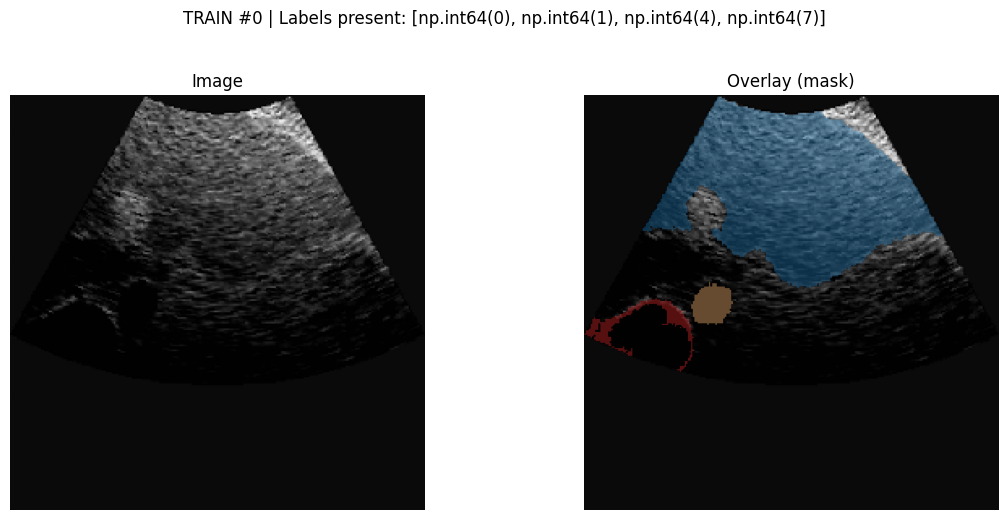

Val sample  :


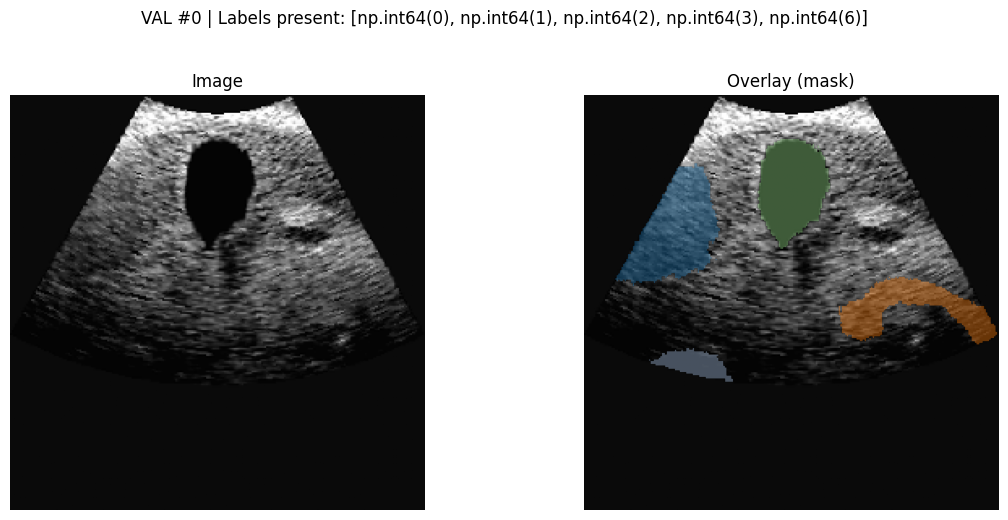

Test sample :


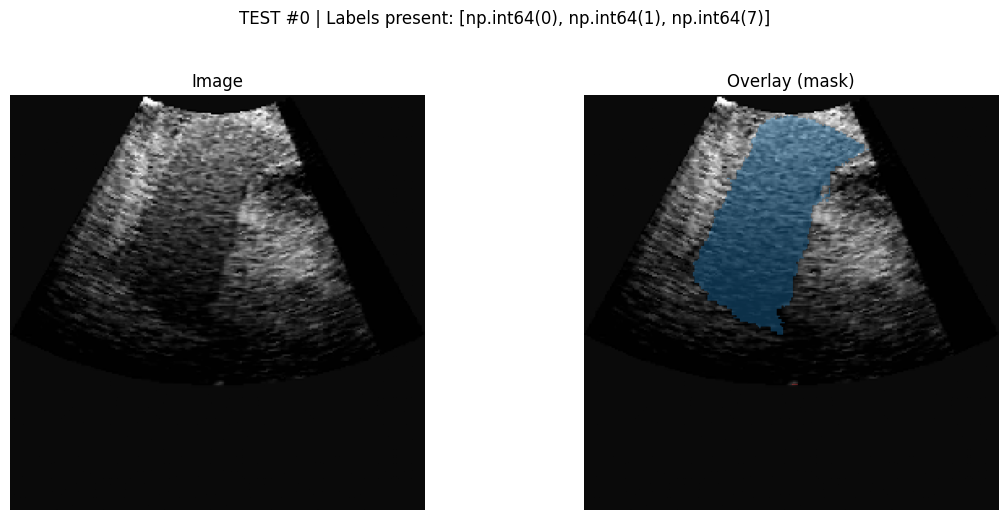

In [ ]:


from matplotlib.colors import ListedColormap, BoundaryNorm
def build_discrete_cmap(max_label_id):
    base = plt.get_cmap("tab20").colors
    colors = []
    for i in range(max_label_id + 1):
        if i == 0: colors.append((0.85,0.85,0.85))
        else:      colors.append(base[(i-1) % len(base)])
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(np.arange(-0.5, max_label_id+1.5, 1), cmap.N)
    return cmap, norm

def show_image_mask(sample, title=None, alpha=0.4):
    # sample may be (img, mask) or {'image','mask'}
    if isinstance(sample, (tuple, list)):
        image, mask = sample[0], sample[1]
    else:
        image, mask = sample["image"], sample["mask"]

    img = to_numpy_image(image)
    msk = to_numpy_mask(mask)
    present = np.unique(msk)
    max_id = int(present.max()) if present.size > 0 else 0
    cmap, norm = build_discrete_cmap(max_id)

    fig, axes = plt.subplots(1,2, figsize=(12,5))
    axes[0].imshow(img); axes[0].set_title("Image"); axes[0].axis("off")
    axes[1].imshow(img)
    axes[1].imshow(np.ma.masked_where(msk==0, msk), cmap=cmap, norm=norm, alpha=alpha)
    axes[1].set_title("Overlay (mask)"); axes[1].axis("off")
    if not title: title = "Sample"
    fig.suptitle(f"{title} | Labels present: {list(present)}", y=1.03)
    plt.tight_layout(); plt.show()

print("Train sample:"); show_image_mask(train_ds_raw[0], "TRAIN #0")
print("Val sample  :"); show_image_mask(val_ds_raw[0],   "VAL #0")
print("Test sample :"); show_image_mask(test_ds_raw[0],  "TEST #0")


## **🏷️ Cell 8 — Discovering Dataset Labels**
Next, we explore the segmentation masks to figure out which labels (organs/structures) are actually present.  

1. **`discover_labels(ds, n=500)`**  
   - Iterates through up to `n` samples from a dataset split.  
   - Collects all unique label IDs found in the segmentation masks.  
   - Returns the list of distinct labels.  

2. **Apply to all splits**  
   - We run this on the training, validation, and test sets separately.  
   - This helps confirm consistency across splits (i.e., the same labels appear everywhere).  

3. **Infer number of classes**  
   - Combine all discovered labels.  
   - The highest label ID + 1 gives us the total number of classes (`NUM_CLASSES`).  

Finally, we print out the labels per split and the inferred number of classes our model will need to predict.  


In [ ]:
def discover_labels(ds, n=500):
    seen = set()
    for i in range(min(n, len(ds))):
        s = ds[i]
        m = s[1] if isinstance(s, (tuple, list)) else s["mask"]
        seen.update(np.unique(to_numpy_mask(m)).tolist())
    return sorted(seen)

labels_train = discover_labels(train_ds_raw, n=500)
labels_val   = discover_labels(val_ds_raw,   n=500)
labels_test  = discover_labels(test_ds_raw,  n=500)
print("Labels (train):", labels_train)
print("Labels (val)  :", labels_val)
print("Labels (test) :", labels_test)

NUM_CLASSES = int(max(labels_train + labels_val + labels_test)) + 1
print("→ NUM_CLASSES inferred:", NUM_CLASSES)


Labels (train): [0, 1, 2, 3, 4, 5, 6, 7, 8]
Labels (val)  : [0, 1, 2, 3, 4, 5, 6, 7, 8]
Labels (test) : [0, 1, 2, 3, 4, 5, 6, 7, 8]
→ NUM_CLASSES inferred: 9


## **⚙️ Cell 9 — Custom Dataset Class & Data Loaders**
To prepare our dataset for training with **DeepLabV3+**, we define a custom PyTorch dataset wrapper and build efficient data loaders.  

1. **ImageNet Normalization**  
   - Since DeepLabV3+ uses a pretrained backbone, we normalize images using the standard ImageNet mean and standard deviation.  
   - This helps the model benefit from transfer learning.  

2. **`TorchSegDataset` class**  
   - Wraps the raw dataset into PyTorch’s `Dataset` format.  
   - Converts images/masks into the correct tensor format.  
   - Ensures grayscale images are expanded to 3 channels (RGB).  
   - Applies **random flips** (horizontal & vertical) for data augmentation during training.  
   - Normalizes images if enabled, and returns:  
     - `image`: float tensor `[3, H, W]`  
     - `mask`: long tensor `[H, W]`  

3. **Train / Validation / Test Datasets**  
   - Create three separate dataset objects, enabling augmentation only for training.  

4. **Data Loaders**  
   - Batch size set to `8`.  
   - Use multiple workers and pinned memory for efficiency if running on GPU.  
   - Training loader also shuffles data and drops the last incomplete batch for consistency.  

Finally, we check how many batches are available in each split (train, val, test).  


In [ ]:
# DeepLabV3+ with pretrained backbone benefits from ImageNet normalization
IMAGENET_NORMALIZE = True
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

class TorchSegDataset(Dataset):
    """
    Returns:
      image: float tensor [3,H,W] in [0,1] (optionally normalized)
      mask : long  tensor [H,W]
    """
    def __init__(self, base_ds, train=True, normalize=IMAGENET_NORMALIZE):
        self.base = base_ds
        self.train = train
        self.normalize = normalize

    def __len__(self): return len(self.base)

    def _to_np(self, x):
        if isinstance(x, np.ndarray): return x
        if isinstance(x, torch.Tensor): return x.detach().cpu().numpy()
        return np.array(x)  # PIL -> np

    def __getitem__(self, idx):
        s = self.base[idx]
        img = s[0] if isinstance(s, (tuple, list)) else s["image"]
        msk = s[1] if isinstance(s, (tuple, list)) else s["mask"]

        img = self._to_np(img)  # HxW or HxWxC
        msk = self._to_np(msk)  # HxW
        if img.ndim == 2:
            img = img[..., None]

        # paired flips
        if self.train:
            if random.random() < 0.5:
                img = np.flip(img, axis=1).copy(); msk = np.flip(msk, axis=1).copy()
            if random.random() < 0.3:
                img = np.flip(img, axis=0).copy(); msk = np.flip(msk, axis=0).copy()

        img = img.astype(np.float32)
        if img.max() > 1.5: img = img / 255.0
        if img.shape[2] == 1: img = np.repeat(img, 3, axis=2)

        img_t = torch.from_numpy(img.transpose(2,0,1))   # [C,H,W], 0..1
        if self.normalize:
            img_t = (img_t - IMAGENET_MEAN) / IMAGENET_STD
        msk_t = torch.from_numpy(msk.astype(np.int64))    # [H,W]
        return img_t, msk_t

train_ds = TorchSegDataset(train_ds_raw, train=True)
val_ds   = TorchSegDataset(val_ds_raw,   train=False)
test_ds  = TorchSegDataset(test_ds_raw,  train=False)

BATCH_SIZE = 8
pin_mem = torch.cuda.is_available()
num_workers = 2 if pin_mem else 0

# when creating loaders for DeepLabV3+
train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=num_workers, pin_memory=pin_mem, drop_last=True  # ← add this
)


val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=num_workers, pin_memory=pin_mem
)
test_loader = DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=num_workers, pin_memory=pin_mem
)


len(train_loader), len(val_loader), len(test_loader)


(71, 8, 37)

## **🏗️ Cell 10 — Building DeepLabV3+ Model**
Now we set up our **DeepLabV3+ segmentation model** with the correct number of output classes.  

1. **Load Pretrained Backbone**  
   - We use **ResNet-50** as the backbone, pretrained on ImageNet.  
   - This provides strong feature extraction from the start, improving training performance.  
   - Code supports both the newer and older `torchvision` APIs for compatibility.  

2. **Modify the Classifier Head**  
   - By default, DeepLabV3+ is configured for 21 classes (COCO/VOC).  
   - We replace the final **1×1 convolution layer** so the model predicts `NUM_CLASSES` segmentation classes for our dataset.  

3. **Modify the Auxiliary Head**  
   - If present, the auxiliary classifier (used for deep supervision) is also updated to output `NUM_CLASSES`.  

4. **Move Model to Device**  
   - The model is moved to GPU if available, otherwise runs on CPU.  

Finally, we print the total number of trainable parameters (in millions) to get a sense of model size.  


In [ ]:
# Build DeepLabV3+ and replace its final layers for NUM_CLASSES
from torchvision import models

def build_deeplabv3_plus(num_classes):
    try:
        # Newer API (weights enum)
        from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
        weights = DeepLabV3_ResNet50_Weights.DEFAULT  # ImageNet pretrained
        model = deeplabv3_resnet50(weights=weights, aux_loss=True)
    except Exception:
        # Fallback for older torchvision
        from torchvision.models.segmentation import deeplabv3_resnet50
        model = deeplabv3_resnet50(pretrained=True, aux_loss=True)

    # Replace classifier head
    if isinstance(model.classifier, nn.Sequential) and isinstance(model.classifier[-1], nn.Conv2d):
        in_ch = model.classifier[-1].in_channels
        model.classifier[-1] = nn.Conv2d(in_ch, num_classes, kernel_size=1)
    else:
        # generic fallback
        for m in reversed(list(model.classifier.modules())):
            if isinstance(m, nn.Conv2d) and m.out_channels in (21, 19, 2):
                m.out_channels = num_classes  # not ideal, but most builds have Sequential

    # Replace aux head (if present)
    if model.aux_classifier is not None:
        if isinstance(model.aux_classifier, nn.Sequential) and isinstance(model.aux_classifier[-1], nn.Conv2d):
            in_ch = model.aux_classifier[-1].in_channels
            model.aux_classifier[-1] = nn.Conv2d(in_ch, num_classes, kernel_size=1)

    return model

model = build_deeplabv3_plus(NUM_CLASSES).to(DEVICE)
print("Params (M):", sum(p.numel() for p in model.parameters())/1e6)


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


100%|██████████| 161M/161M [00:02<00:00, 62.0MB/s]


Params (M): 41.997906


## **📉 Cell 11 — Loss Functions, Metrics, and Optimizer Setup**
To train and evaluate our segmentation model, we define the key ingredients:  

1. **Soft Dice Loss (`soft_dice_loss`)**  
   - Measures overlap between predicted masks and ground truth.  
   - Helps deal with class imbalance by focusing on regions of interest.  
   - Works per class, then averages across all classes.  

2. **Evaluation Metrics (`compute_metrics`)**  
   - Uses **IoU (Intersection over Union)** and **Dice Score** as evaluation metrics.  
   - These are common in segmentation tasks to measure how well predicted regions match the ground truth.  
   - Background pixels (index `0`) are **ignored** to avoid bias.  

3. **Class Weights for Cross-Entropy**  
   - Ultrasound datasets often have imbalance (some organs appear less frequently).  
   - We scan the training set and compute inverse-frequency weights.  
   - These weights are applied in **CrossEntropyLoss** to ensure rare classes are not overlooked.  

4. **Optimizer & Mixed Precision Training**  
   - We use **AdamW** with weight decay for stable training.  
   - Learning rate: `3e-4`.  
   - If a GPU is available, **Automatic Mixed Precision (AMP)** is enabled with `GradScaler` to speed up training while saving memory.  

Together, this setup ensures balanced learning, robust optimization, and reliable evaluation for the segmentation model.  


In [ ]:
def soft_dice_loss(logits, targets, num_classes, eps=1e-6, ignore_index=None):
    N, C, H, W = logits.shape
    probs = F.softmax(logits, dim=1)
    tgt_oh = F.one_hot(torch.clamp(targets, min=0), num_classes=num_classes).permute(0,3,1,2).float()
    if ignore_index is not None:
        valid = (targets != ignore_index).float()
        probs = probs * valid.unsqueeze(1)
        tgt_oh = tgt_oh * valid.unsqueeze(1)
    dims = (0,2,3)
    inter = torch.sum(probs * tgt_oh, dims)
    card  = torch.sum(probs + tgt_oh, dims)
    dice_per_class = (2*inter + eps) / (card + eps)
    if ignore_index is not None and 0 <= ignore_index < num_classes:
        dice_per_class = dice_per_class[torch.arange(num_classes) != ignore_index]
    return 1.0 - dice_per_class.mean()

def compute_metrics(logits, targets, num_classes, ignore_index=None, eps=1e-6):
    with torch.no_grad():
        preds = torch.argmax(logits, dim=1)
        valid = (targets != ignore_index) if ignore_index is not None else torch.ones_like(targets, dtype=torch.bool)
        ious, dices = [], []
        for cls in range(num_classes):
            if ignore_index is not None and cls == ignore_index: continue
            pc = (preds==cls) & valid
            tc = (targets==cls) & valid
            inter = (pc & tc).sum().item()
            union = (pc | tc).sum().item()
            denom = (pc.sum() + tc.sum()).item()
            iou  = inter / (union + eps)
            dice = (2*inter) / (denom + eps)
            ious.append(iou); dices.append(dice)
        return float(np.mean(ious)) if ious else 0.0, float(np.mean(dices)) if dices else 0.0

# Ignore background in metrics (helps ultrasound reporting)
IGNORE_INDEX = 0

# Class-weighted CE from inverse frequency
def estimate_class_weights(ds, num_classes, scan_items=200):
    counts = np.zeros(num_classes, dtype=np.float64); total = 0
    for i in range(min(scan_items, len(ds))):
        _, m = ds[i]
        m = m.numpy().ravel()
        bc = np.bincount(m, minlength=num_classes).astype(np.float64)
        counts += bc; total += bc.sum()
    freqs = counts / max(total, 1.0)
    w = 1.0 / (freqs + 1e-8)
    w = w / w.mean()
    w = np.clip(w, 0.2, 5.0)
    return torch.tensor(w, dtype=torch.float32)

class_weights = estimate_class_weights(train_ds, NUM_CLASSES).to(DEVICE)
ce_loss = nn.CrossEntropyLoss(weight=class_weights)  # keep bg learnable

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
USE_AMP = torch.cuda.is_available()
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)




/tmp/ipython-input-1008643384.py:56: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)


## **🔁 Cell - 12 Training & Evaluation Loop (`run_epoch`)**

This function defines how our model goes through **one full epoch** of training or evaluation.  
It handles both the forward pass (predictions), loss calculation, metric computation, and (if training) the backward pass for weight updates.  

---

#### Key Steps:
1. **Mode Selection**  
   - If `train_mode=True`, the model learns (parameters get updated).  
   - If `train_mode=False`, the model only evaluates without updating weights.  

2. **Data Handling**  
   - Each batch (`xb`, `yb`) is moved to the GPU (`DEVICE`) for faster computation.  

3. **Forward Pass & Loss Calculation**  
   - Predictions are generated using the model (`logits = model(xb)["out"]`).  
   - Two loss functions are combined:  
     - **Cross-Entropy Loss** → measures pixel-wise classification accuracy.  
     - **Soft Dice Loss** → helps improve segmentation overlap quality.  

4. **Mixed Precision Support (AMP)**  
   - If `USE_AMP=True`, automatic mixed precision is applied, reducing GPU memory usage and speeding up training.  
   - Otherwise, full precision training is used.  

5. **Backward Pass (Training Only)**  
   - In training mode, gradients are computed (`loss.backward()`) and the optimizer updates model weights.  
   - If AMP is enabled, gradients and optimizer steps are scaled properly with `scaler`.  

6. **Metrics Computation**  
   - After each batch, segmentation quality is measured using:  
     - **Mean Intersection-over-Union (mIoU)**  
     - **Mean Dice Score (mDice)**  

7. **Loss & Metrics Tracking**  
   - Loss, mIoU, and mDice are accumulated across all batches.  
   - At the end, averages are returned:  
     ```python
     return avg_loss, avg_miou, avg_mdice
     ```

---

✅ **In short:**  
This function runs the model for one epoch, whether in training or evaluation mode. It computes segmentation losses, updates the model when training, and reports key performance metrics.  


In [ ]:
def run_epoch(loader, train_mode=True):
    model.train(train_mode)
    running_loss = running_miou = running_mdice = 0.0
    count = 0

    if train_mode:
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)

            if USE_AMP:
                with torch.amp.autocast("cuda", enabled=True):
                    logits = model(xb)["out"]
                    loss = ce_loss(logits, yb) + soft_dice_loss(logits, yb, NUM_CLASSES, ignore_index=IGNORE_INDEX)
                miou, mdice = compute_metrics(logits, yb, NUM_CLASSES, ignore_index=IGNORE_INDEX)
                running_loss += loss.item(); running_miou += miou; running_mdice += mdice; count += 1
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                logits = model(xb)["out"]
                loss = ce_loss(logits, yb) + soft_dice_loss(logits, yb, NUM_CLASSES, ignore_index=IGNORE_INDEX)
                miou, mdice = compute_metrics(logits, yb, NUM_CLASSES, ignore_index=IGNORE_INDEX)
                running_loss += loss.item(); running_miou += miou; running_mdice += mdice; count += 1
                loss.backward()
                optimizer.step()
    else:
        with torch.inference_mode():
            for xb, yb in loader:
                xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
                with torch.amp.autocast("cuda", enabled=USE_AMP):
                    logits = model(xb)["out"]
                    loss = ce_loss(logits, yb) + soft_dice_loss(logits, yb, NUM_CLASSES, ignore_index=IGNORE_INDEX)
                miou, mdice = compute_metrics(logits, yb, NUM_CLASSES, ignore_index=IGNORE_INDEX)
                running_loss += loss.item(); running_miou += miou; running_mdice += mdice; count += 1

    return running_loss / count, running_miou / count, running_mdice / count




## **📈 Cell - 13 Training Loop with History, Scheduler, and Early Stopping**

This block trains the **DeepLabV3+ segmentation model** while monitoring validation metrics to adjust learning rates, save the best model, and stop early if progress stalls.

---

#### 🔑 Key Features:

1. **Training History Tracking**
   - Stores losses and metrics (`mIoU`, `mDice`) for both train/val splits.  
   - History is later saved in **`.npz`** and **`.json`** formats for analysis.  

   ```python
   history = {"epoch": [], "train_loss": [], "train_miou": [], "train_mdice": [],
              "val_loss": [], "val_miou": [], "val_mdice": []}


In [ ]:
# Train loop with history, scheduler, early stop
import time
history = {"epoch": [], "train_loss": [], "train_miou": [], "train_mdice": [],
           "val_loss": [], "val_miou": [], "val_mdice": []}

EPOCHS = 100
best_val_dice = -1.0
best_path = "/content/deeplabv3_abdomenus_best.pt"
hist_npz = "/content/deeplabv3_training_history.npz"
hist_json = "/content/deeplabv3_training_history.json"

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=4   # no 'verbose' for wider compatibility
)
patience = 20
stale = 0

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    tr_loss, tr_miou, tr_mdice = run_epoch(train_loader, train_mode=True)
    va_loss, va_miou, va_mdice = run_epoch(val_loader,   train_mode=False)
    dt = time.time() - t0

    history["epoch"].append(epoch)
    history["train_loss"].append(tr_loss); history["train_miou"].append(tr_miou); history["train_mdice"].append(tr_mdice)
    history["val_loss"].append(va_loss);   history["val_miou"].append(va_miou);   history["val_mdice"].append(va_mdice)

    print(f"[{epoch:02d}/{EPOCHS}] {dt:5.1f}s | "
          f"Train: loss={tr_loss:.4f} mIoU={tr_miou:.4f} mDice={tr_mdice:.4f} || "
          f"Val: loss={va_loss:.4f} mIoU={va_miou:.4f} mDice={va_mdice:.4f}")

    # step scheduler on val mDice
    before = [pg["lr"] for pg in optimizer.param_groups]
    scheduler.step(va_mdice)
    after = [pg["lr"] for pg in optimizer.param_groups]
    if after != before:
        print(f"LR reduced: {before} → {after}")

    if va_mdice > best_val_dice:
        best_val_dice = va_mdice
        torch.save({"model": model.state_dict(), "num_classes": NUM_CLASSES, "size": SIZE}, best_path)
        print(f"  ↪︎ Saved best (val mDice={best_val_dice:.4f}) -> {best_path}")
        stale = 0
    else:
        stale += 1
        if stale >= patience:
            print(f"Early stopping (no val mDice gain for {patience} epochs).")
            break

# Save history
np.savez(hist_npz, **history)
with open(hist_json, "w") as f:
    json.dump(history, f, indent=2)
print("✅ Saved history:", hist_npz, "and", hist_json)


[01/100]  13.9s | Train: loss=1.8913 mIoU=0.1614 mDice=0.2035 || Val: loss=1.5514 mIoU=0.1654 mDice=0.2136
  ↪︎ Saved best (val mDice=0.2136) -> /content/deeplabv3_abdomenus_best.pt
[02/100]  11.7s | Train: loss=1.1790 mIoU=0.3082 mDice=0.3808 || Val: loss=1.4046 mIoU=0.2956 mDice=0.3792
  ↪︎ Saved best (val mDice=0.3792) -> /content/deeplabv3_abdomenus_best.pt
[03/100]  11.8s | Train: loss=0.9908 mIoU=0.3991 mDice=0.4963 || Val: loss=0.8652 mIoU=0.4191 mDice=0.5124
  ↪︎ Saved best (val mDice=0.5124) -> /content/deeplabv3_abdomenus_best.pt
[04/100]  11.9s | Train: loss=0.8567 mIoU=0.4523 mDice=0.5456 || Val: loss=0.9814 mIoU=0.3621 mDice=0.4523
[05/100]  12.0s | Train: loss=0.7568 mIoU=0.5076 mDice=0.6014 || Val: loss=0.8804 mIoU=0.4003 mDice=0.4892
[06/100]  12.1s | Train: loss=0.7445 mIoU=0.5118 mDice=0.6076 || Val: loss=1.1455 mIoU=0.3000 mDice=0.3806
[07/100]  12.2s | Train: loss=0.6948 mIoU=0.5433 mDice=0.6368 || Val: loss=0.9295 mIoU=0.3897 mDice=0.4817
[08/100]  12.8s | Train: l

## **📊 Cell - 14  Final Evaluation on Test Set with TTA**

Now that our model is fully trained and the best checkpoint is loaded, it’s time to see how well it performs on the **unseen test set**.  

1. **Load Best Model Weights**  
   - The model checkpoint (`best_path`) is loaded.  
   - We set the model to evaluation mode (`model.eval()`) to disable training-specific behaviors like dropout.  

2. **Test-Time Augmentation (TTA)**  
   - Instead of just feeding the test images directly, we apply a simple trick called **Test-Time Augmentation (TTA)**.  
   - Here, we run predictions twice:
     - Once on the original image.  
     - Once on a horizontally flipped version of the image, then flip predictions back.  
   - Finally, we average both predictions to make them more robust.  

3. **Evaluation Loop**  
   - For every batch in the test set:
     - Predictions are obtained using `logits_with_tta`.  
     - The **loss** is computed using a combination of **Cross-Entropy Loss** and **Soft Dice Loss**.  
     - Metrics are calculated:
       - **mIoU (Mean Intersection over Union)**  
       - **mDice (Mean Dice Coefficient)**  
   - These values are accumulated across all test batches.  

4. **Results**  
   - After going through the test set, the script prints out the final averaged metrics:  
     - ✅ **Test Loss**  
     - 🎯 **Mean IoU**  
     - 💡 **Mean Dice**  

This step gives us the ultimate performance of our segmentation model on completely unseen data, ensuring that we measure **generalization ability** rather than just memorization of the training set.


In [ ]:
ckpt = torch.load(best_path, map_location=DEVICE)
model.load_state_dict(ckpt["model"])
model.eval()

def logits_with_tta(xb):
    with torch.no_grad(), torch.amp.autocast("cuda", enabled=(DEVICE=="cuda")):
        p1 = model(xb)["out"]
        p2 = model(torch.flip(xb, dims=[3]))["out"]; p2 = torch.flip(p2, dims=[3])
        return (p1 + p2) / 2

test_loss = test_miou = test_mdice = 0.0
count = 0
with torch.inference_mode():
    for xb, yb in test_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        with torch.amp.autocast("cuda", enabled=(DEVICE=="cuda")):
            logits = logits_with_tta(xb)  # or: model(xb)["out"]
            loss = ce_loss(logits, yb) + soft_dice_loss(logits, yb, NUM_CLASSES, ignore_index=IGNORE_INDEX)
        miou, mdice = compute_metrics(logits, yb, NUM_CLASSES, ignore_index=IGNORE_INDEX)
        test_loss += loss.item(); test_miou += miou; test_mdice += mdice; count += 1

print(f"TEST: loss={test_loss/count:.4f} | mIoU={test_miou/count:.4f} | mDice={test_mdice/count:.4f}")


TEST: loss=0.8345 | mIoU=0.4821 | mDice=0.5565


## **🔮 Cell - 15 Visualizing Model Predictions vs Ground Truth**

To evaluate how well our trained segmentation model is performing, we define a helper function called `predict_overlay`.  
This function overlays the predicted masks on top of the original images and compares them with the **ground truth masks**.

Here’s what happens step by step:

1. **Model Evaluation Mode**  
   The model is set to evaluation mode (`model.eval()`) so dropout and batch normalization behave correctly during inference.

2. **Random Sample Selection**  
   A few random samples (`n=3` by default) are selected from the dataset to visualize predictions.

3. **Prediction**  
   - Each selected image is passed through the model.  
   - The output logits are converted to class predictions using `argmax`.

4. **Overlay Preparation**  
   - The original image, ground truth mask, and predicted mask are prepared.  
   - A discrete colormap (`cmap`) is used to distinguish segmentation classes clearly.  
   - Masks are overlayed with transparency (`alpha=0.4`) so the underlying image is still visible.

5. **Visualization**  
   - For each chosen sample, three plots are shown side by side:  
     - **Original Image**  
     - **Ground Truth Mask Overlay**  
     - **Predicted Mask Overlay**

Finally, we run the function on a few images from the **validation set** to visually inspect how well our segmentation model generalizes.

```python
# Preview a few from validation set
predict_overlay(val_ds, n=4)


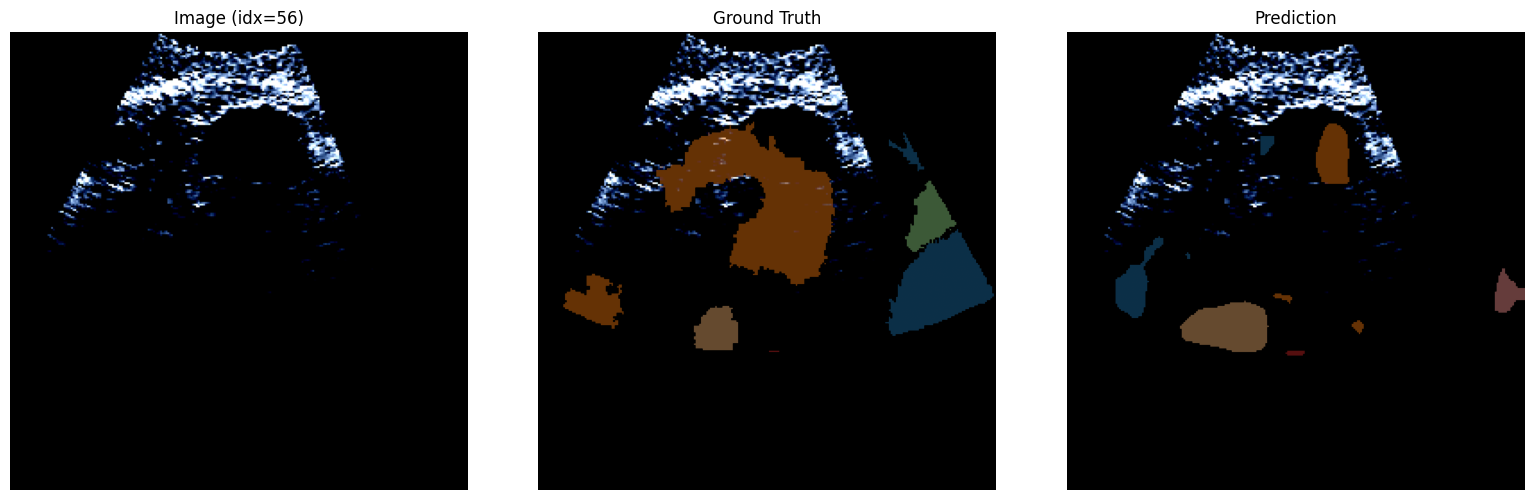

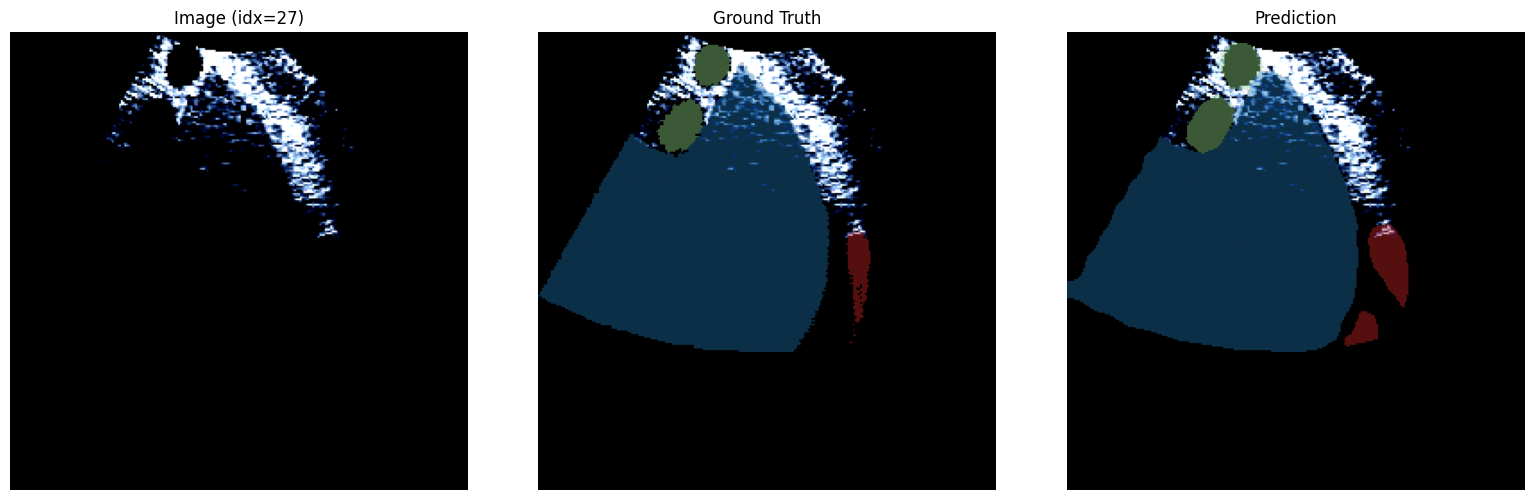

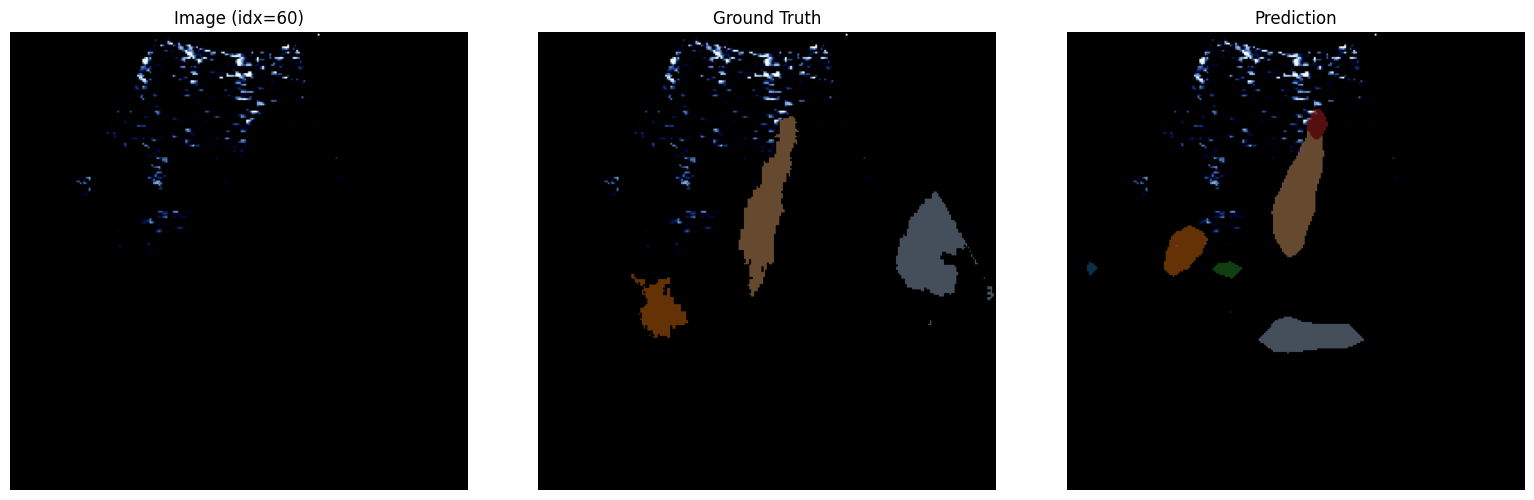

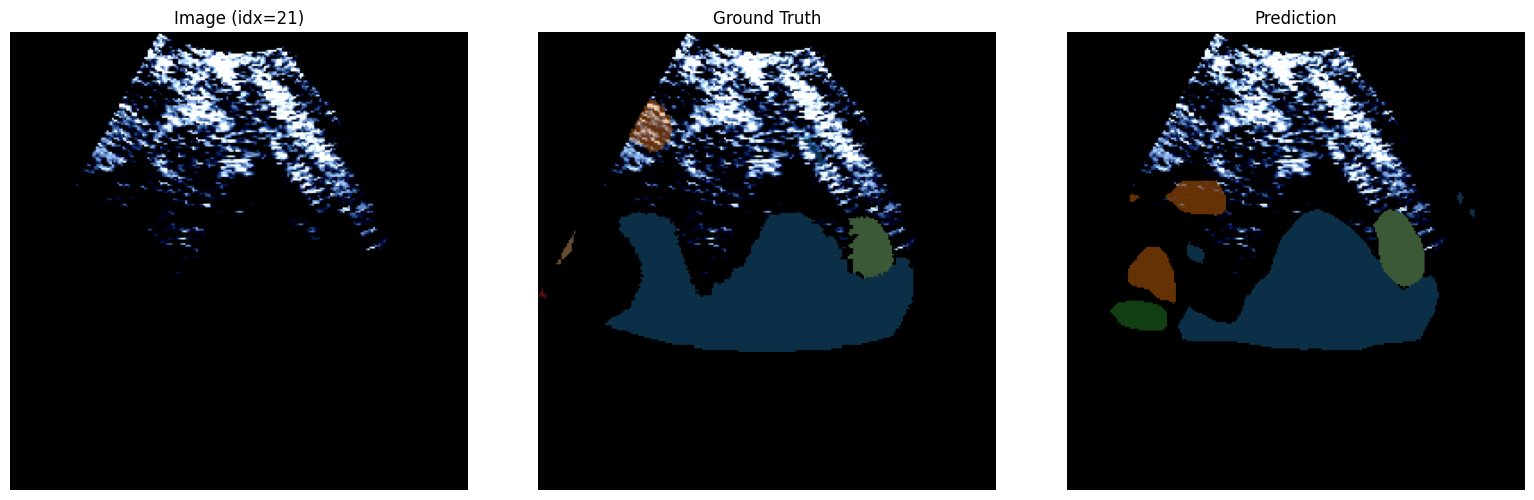

In [ ]:
def predict_overlay(ds, n=3, alpha=0.4):
    model.eval()
    idxs = random.sample(range(len(ds)), k=min(n, len(ds)))
    for i in idxs:
        img_t, msk_t = ds[i]
        with torch.no_grad(), torch.amp.autocast("cuda", enabled=(DEVICE=="cuda")):
            logits = model(img_t.unsqueeze(0).to(DEVICE))["out"]
            pred = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()

        img_np = np.transpose(img_t.numpy(), (1,2,0))
        msk_np = msk_t.numpy()
        max_id = int(max(msk_np.max(), pred.max()))
        cmap, norm = build_discrete_cmap(max_id)

        fig, axes = plt.subplots(1,3, figsize=(16,5))
        axes[0].imshow(img_np); axes[0].set_title(f"Image (idx={i})"); axes[0].axis("off")
        axes[1].imshow(img_np); axes[1].imshow(np.ma.masked_where(msk_np==0, msk_np), cmap=cmap, norm=norm, alpha=alpha); axes[1].set_title("Ground Truth"); axes[1].axis("off")
        axes[2].imshow(img_np); axes[2].imshow(np.ma.masked_where(pred==0, pred),     cmap=cmap, norm=norm, alpha=alpha); axes[2].set_title("Prediction");   axes[2].axis("off")
        plt.tight_layout(); plt.show()

# Preview a few from validation set
predict_overlay(val_ds, n=4)


## **📉 Cell - 16 Training Progress Visualization**

After training our DeepLabV3 model, it’s important to visualize how the training and validation performance evolved over time.  
We saved the history (losses and metrics per epoch) into a `.npz` file for later use. If running in a new session, the history can be reloaded from the file.

The function `plot_metric(...)` helps us compare training vs validation trends by plotting them side by side.  
Here, we plot **Loss over Epochs** to check if the model converged properly without overfitting.

- **X-axis:** Epochs  
- **Y-axis:** Loss values  
- **Blue curve:** Training loss  
- **Orange curve:** Validation loss  

This visualization gives us a quick sense of whether the model is learning effectively and generalizing well.  
We also save the plots as images (`deeplabv3_plot_loss.png`) for future reference or reports.


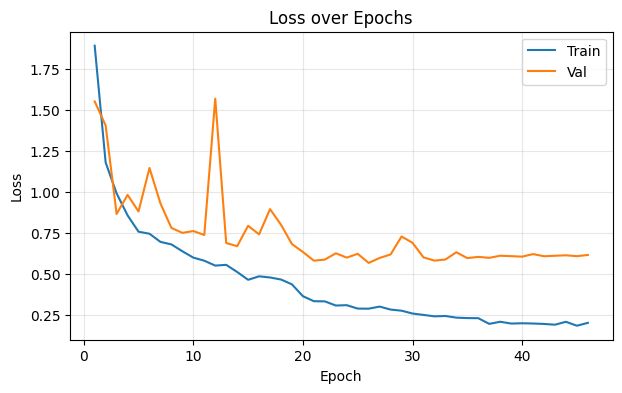

Saved plots to /content/deeplabv3_plot_*.png


In [ ]:
# If running in a fresh session, reload:
# data = np.load("/content/deeplabv3_training_history.npz", allow_pickle=True)
# history = {k: data[k].tolist() for k in data.files}

epochs = history["epoch"]

def plot_metric(epochs, train_vals, val_vals, title, ylabel, save_path=None):
    plt.figure(figsize=(7,4))
    plt.plot(epochs, train_vals, label="Train")
    plt.plot(epochs, val_vals,   label="Val")
    plt.xlabel("Epoch"); plt.ylabel(ylabel); plt.title(title)
    plt.grid(True, alpha=0.3); plt.legend()
    if save_path: plt.savefig(save_path, bbox_inches="tight", dpi=150)
    plt.show()

plot_metric(epochs, history["train_loss"], history["val_loss"], "Loss over Epochs", "Loss",
            "/content/deeplabv3_plot_loss.png")

print("Saved plots to /content/deeplabv3_plot_*.png")


## **📊 Cell - 17 Mean Intersection over Union (mIoU) Tracking**

Besides loss, one of the most important metrics in semantic segmentation is **Mean Intersection over Union (mIoU)**.  
It tells us how well the predicted masks overlap with the ground truth across all classes.

Using our `plot_metric(...)` function, we now plot **mIoU o**_


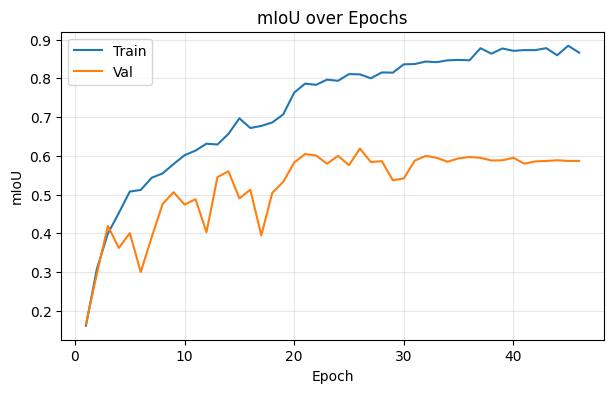

In [ ]:
plot_metric(epochs, history["train_miou"], history["val_miou"], "mIoU over Epochs", "mIoU",
            "/content/deeplabv3_plot_mIoU.png")


## **🎯 Cell - 18 Mean Dice Coefficient (mDice) Tracking**

Another popular evaluation metric in segmentation tasks is the **Mean Dice Coefficient (mDice)**.  
It measures the overlap between the predicted masks and the ground truth, ranging from 0 (no overlap) to 1 (perfect overlap).  
Compared to mIoU, Dice is often more sensitive to smaller structures in the image.

Using our `plot_metric(...)` function, we now visualize **mDice over Epochs**:

- **X-axis:** Epochs  
- **Y-axis:** mDice values  
- **Blue curve:** Training mDice  
- **Orange curve:** Validation mDice  

This curve allows us to verify how well the model is learning to segment objects accurately.  
The figure is also saved as `deeplabv3_plot_mDice.png` for future reference.


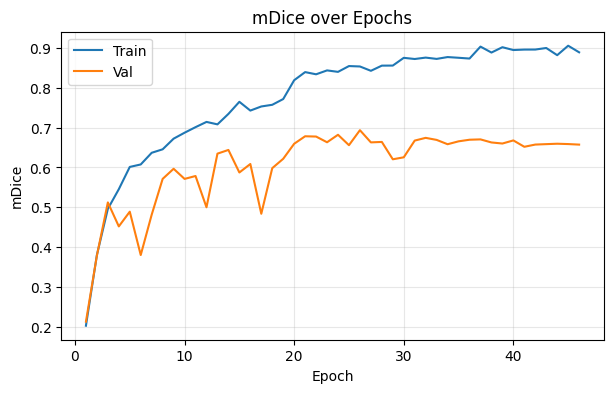

In [ ]:
plot_metric(epochs, history["train_mdice"], history["val_mdice"], "mDice over Epochs", "mDice",
            "/content/deeplabv3_plot_mDice.png")